---
title: Classifying Penguins
author: Mead Gyawu
date: '2023-05-10'
description: "Classifying Penguins"
format: html
---

### Classifying Penguins

#### Goal

Finding the 3 best features for a model to classify 3 different species of penguins.



#### Table of All the Data

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)
X_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,41.1,17.5,190.0,3900.0,8.94365,-26.06943,0,1,0,1,0,1,0,1
270,45.4,14.6,211.0,4800.0,8.24515,-25.46782,1,0,0,1,0,1,1,0
271,36.2,17.2,187.0,3150.0,9.04296,-26.19444,0,0,1,1,1,0,1,0
272,50.0,15.9,224.0,5350.0,8.20042,-26.39677,1,0,0,1,0,1,0,1


#### Decision Tree Classifier

The model that I chose to work with is a Decision Tree Classifier. Here is how it performs without any method of feature selection:

In [96]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)


DecisionTreeClassifier()

In [97]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

y_pred = tree.predict(X_test)

print("Accuracy of Decision Tree: "+ str(accuracy_score(y_test,y_pred)))

Accuracy of Decision Tree: 0.9411764705882353


In order to determine the 3 best feature, I employed recursive feature selection to get a ranking of the most impactful features on classification.

In [104]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE

svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=3)
rfe.fit(X_train, y_train)
ranking = rfe.ranking_#.reshape(X_train.shape)
print(ranking)

[ 3  2  8 11  6  1  1  5  7 12 10  9  4  1]


The Rankings go as follows:
1. Sex_MALE, Island_Biscoe
2. Culmen Depth
3. Culmen Length

The 3 features I chose were are Culmen Length (mm), Culmen Depth (mm), and Sex_MALE. Because Sex_MALE concerns gender, I included Sex_FEMALE as well.

In [103]:
qual = ['Island_Biscoe',
 'Island_Dream', 'Island_Torgersen', 'Stage_Adult, 1 Egg Stage',
 'Clutch Completion_No', 'Clutch Completion_Yes', 'Sex_FEMALE', 'Sex_MALE']

quant = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

cols = []
i = 1
while i < 4:
    index = list(rfe.ranking_)[::-1].index(i)
    cols.append(X_train.columns.values[::-1][index])
    i += 1


new_cols = []
for i in cols:
    if i in qual: new_cols.append(i)
    if i in quant: new_cols.insert(0, i)

if 'Sex_MALE' in new_cols: new_cols.append('Sex_FEMALE')

print(new_cols)

['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_MALE', 'Sex_FEMALE']


#### Table Plotting and Accuracy


Here is a table of the features chosen for my decision tree. The features in this table are grouped by Sex_MALE, and the other columns represent the average value of each of the other features chosen.

In [106]:
#Table of supposed best columns
print(new_cols)
table = X_train.groupby('Sex_MALE').aggregate({
    'Culmen Depth (mm)': "mean",
    'Culmen Length (mm)' : "mean",
    'Sex_FEMALE' : "mean"
})
table

['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_MALE', 'Sex_FEMALE']


,Culmen Depth (mm),Culmen Length (mm),Sex_FEMALE
Sex_MALE,,,
0,16.509524,42.051587,1.0
1,17.745385,46.364615,0.0


Here is the accuracy of the decision tree now that we trained it on only these 3 features:

In [111]:
tree = DecisionTreeClassifier()
tree.fit(X_train[new_cols],y_train)


y_pred = tree.predict(X_test[new_cols])

print("Accuracy of Decision Tree with these 3 features: "+ str(accuracy_score(y_test,y_pred)))

Accuracy of Decision Tree with these 3 features: 0.9852941176470589


As we can all see, there has been an increase in measured accuracy from the initial tree that we had to the tree trained on the selected features. In addition, if you look at the table, there is a strong correlation between larger measurements for Culmen length and depth with being Male. Considering that these are the 3 best features for classifying the penguins, it would make sense that there would be a strong correlation between these 3 features.


### Visualizing Decision Regions

Here is a visualization of the decision regions for the 3 species of penguins based on the features I have chosen.

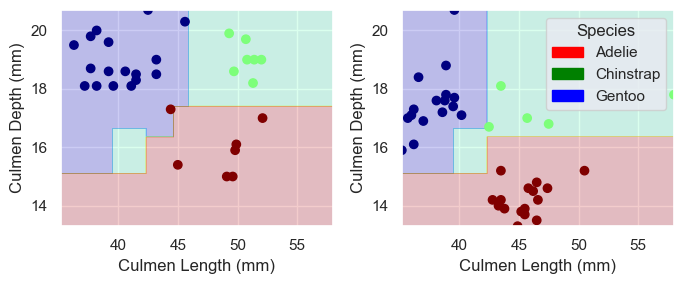

In [102]:

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import numpy as np

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

plot_regions(tree, X_test[new_cols], y_test)